In [1]:
# Importing necessary modules

import pandas as pd

In [2]:
# Function declarations

def convertToImpliedProbability(decimal_odds):
    return 1/decimal_odds

def elo_calculator(elo_1, elo_2):
    return 1 / (1+(pow(10,((elo_2 - elo_1)/400)))), 1 / (1+(pow(10,((elo_1 - elo_2)/400))))

In [3]:
# Base dataframe : holds match and odds info

df_1819 = pd.read_csv('premier_league_18_19.csv')

df = df_1819[['Date', 'HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A']].copy()
df['HomeDNB'] = df['B365H'] * (df['B365D'] - 1) / df['B365D']
df['AwayDNB'] = df['B365A'] * (df['B365D'] - 1) / df['B365D']
df['HomeDNBAdj'] = df['HomeDNB'].apply(convertToImpliedProbability)
df['AwayDNBAdj'] = df['AwayDNB'].apply(convertToImpliedProbability)
df['HomeDNBNorm'] = df['HomeDNBAdj'] *  (1 / (df['HomeDNBAdj'] + df['AwayDNBAdj']))
df['AwayDNBNorm'] = df['AwayDNBAdj'] *  (1 / (df['HomeDNBAdj'] + df['AwayDNBAdj']))

df2 = df[['Date', 'HomeTeam', 'AwayTeam', 'HomeDNBNorm', 'AwayDNBNorm']].copy()

# df2 now holds the date, the home team, the away team and each team's normalized/hedged DNB odds for that fixture.

In [4]:
len(df2)

380

In [5]:
# Weekly ELO dictionary
# Retrieve info by doing elo_dict[team][round], e.g elo_dict['Man United'][2] returns 1399.56

elo_by_round = pd.read_csv('elo_by_round_18-19.csv')
elo_dict = {}

for _, row in elo_by_round.iterrows():
    team = row['team']
    rd = row['round']
    elo = row['elo']
    if team not in elo_dict:
        elo_dict[team] = {}
    elo_dict[team][rd] = elo

In [6]:
# Getting Matchday info, concatting to DF3

matchday_df = pd.read_csv('england-premier-league-matches-2018-to-2019-stats.csv')
pl_matchday = matchday_df[['date_GMT', 'Game Week', 'home_team_name', 'away_team_name', 'stadium_name']].copy()

import difflib

def replace_with_closest(df, column, values):
    for i, row in df.iterrows():
        closest_value = difflib.get_close_matches(row[column], values, n=1)
        if closest_value:
            df.at[i, column] = closest_value[0]
            
replace_with_closest(pl_matchday, 'home_team_name', list(df2['HomeTeam'].unique()))
replace_with_closest(pl_matchday, 'away_team_name', list(df2['HomeTeam'].unique()))

pl_matchday['home_team_name'] = pl_matchday['home_team_name'].str.replace('Wolverhampton Wanderers', 'Wolves')
pl_matchday['away_team_name'] = pl_matchday['away_team_name'].str.replace('Wolverhampton Wanderers', 'Wolves')

pl_matchday['home_team_name'] = pl_matchday['home_team_name'].str.replace('Brighton & Hove Albion', 'Brighton')
pl_matchday['away_team_name'] = pl_matchday['away_team_name'].str.replace('Brighton & Hove Albion', 'Brighton')


pl_matchday = pl_matchday[['home_team_name', 'away_team_name', 'Game Week', 'stadium_name']]

df3 = df2.merge(pl_matchday, left_on = ['HomeTeam', 'AwayTeam'], right_on = ['home_team_name', 'away_team_name'], how = 'left').drop(['home_team_name', 'away_team_name'], axis = 1)

In [7]:
# Setting ELO values to the original dataframe

def setEloProbabilities (row):
    home_prob, away_prob = elo_calculator(elo_dict[row['HomeTeam']][row['Game Week']], elo_dict[row['AwayTeam']][row['Game Week']])
    return [home_prob, away_prob]

df3['EloProbabilities'] = df3.apply (lambda row: setEloProbabilities(row), axis=1)

In [8]:
# Once we have the ELO ratings and probabilities for each team, we're going to project.

In [9]:
df3['Date'] = pd.to_datetime(df3['Date'], format = "%d/%m/%Y")

In [10]:
# Adding weather data and compiling the dataframe to 'final_df'

weather_df = pd.read_csv('weather.csv')
replace_with_closest(weather_df, 'name', list(df3['stadium_name'].unique()))
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])

final_df = df3.merge(weather_df[['stadium_name', 'datetime', 'feelslike', 'is_rainy', 'is_cloudy', 'is_snowy']], 
                     left_on = ['stadium_name', 'Date'], right_on = ['stadium_name', 'datetime'] )
final_df['HomeProbabilityDifference'] = final_df['HomeDNBNorm'] - final_df['EloProbabilities'].str[0]

In [11]:
# Auxiliary functions

def add_is_home_column(dataframe, team_name):
    
    dataframe['isHome'] = dataframe['HomeTeam'].apply(lambda x: 1 if x == team_name else 0)
    return dataframe

def add_columns(dataframe, team_name):
    def calculate_odd_diff(row):
        if row['HomeTeam'] == team_name:
            odd = row['EloProbabilities'][0]
            diff = row['HomeDNBNorm'] - odd
        else:
            odd = row['EloProbabilities'][1]
            diff = row['AwayDNBNorm'] - odd
        return diff
    
    dataframe['TeamOddDiff'] = dataframe.apply(calculate_odd_diff, axis=1)
    
    return dataframe

def getTeamReport(final_df, team_name):
    
    df = final_df[(final_df['HomeTeam'] == team_name) | (final_df['AwayTeam'] == team_name)].reset_index(drop = True)
    df = add_is_home_column(df, team_name)
    df = add_columns(df, team_name)
    
    return df

In [12]:
final_df

,Date,HomeTeam,AwayTeam,HomeDNBNorm,AwayDNBNorm,Game Week,stadium_name,EloProbabilities,datetime,feelslike,is_rainy,is_cloudy,is_snowy,HomeProbabilityDifference
0,2018-08-10,Man United,Leicester,0.826902,0.173098,1,Old Trafford (Manchester),"[0.7763145538510492, 0.22368544614895072]",2018-08-10,12.7,1,1,0,0.050587
1,2018-08-11,Bournemouth,Cardiff,0.703125,0.296875,1,Vitality Stadium (Bournemouth- Dorset),"[0.6692558476180058, 0.3307441523819942]",2018-08-11,14.0,1,1,0,0.033869
2,2018-08-11,Fulham,Crystal Palace,0.545455,0.454545,1,Craven Cottage (London),"[0.3037251272014306, 0.6962748727985694]",2018-08-11,15.7,1,1,0,0.241729
3,2018-08-11,Huddersfield,Chelsea,0.198520,0.801480,1,John Smith's Stadium (Huddersfield- West Yorks...,"[0.24610090979081675, 0.7538990902091832]",2018-08-11,13.9,1,1,0,-0.047581
4,2018-08-11,Newcastle,Tottenham,0.343434,0.656566,1,St. James' Park (Newcastle upon Tyne),"[0.23790731392676812, 0.7620926860732319]",2018-08-11,13.8,1,1,0,0.105527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2019-05-12,Liverpool,Wolves,0.894309,0.105691,38,Anfield (Liverpool),"[0.8245288054569566, 0.17547119454304333]",2019-05-12,9.7,0,1,0,0.069780
376,2019-05-12,Man United,Cardiff,0.895765,0.104235,38,Old Trafford (Manchester),"[0.7542833775092578, 0.24571662249074216]",2019-05-12,8.8,0,1,0,0.141482
377,2019-05-12,Southampton,Huddersfield,0.855131,0.144869,38,St. Mary's Stadium (Southampton- Hampshire),"[0.7461722527916836, 0.25382774720831625]",2019-05-12,10.3,0,1,0,0.108959
378,2019-05-12,Tottenham,Everton,0.614035,0.385965,38,Tottenham Hotspur Stadium (London),"[0.5114533569476217, 0.4885466430523782]",2019-05-12,10.8,1,1,0,0.102582


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

list_of_teams = []
home_importance = []
rain_importance = []
temperature_importance = []

for i in final_df['HomeTeam'].unique():
    
    chelsea_df = getTeamReport(final_df, i)

    X = chelsea_df[['is_rainy', 'isHome']]
    y = chelsea_df['TeamOddDiff']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestRegressor(n_estimators=1000, random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)


    importances = model.feature_importances_
    print(i)
    print("Feature ranking:")
    print(importances)
    
    list_of_teams.append(i)
    home_importance.append(importances[1])
    rain_importance.append(importances[0])
    #temperature_importance.append(importances[0])

Man United
Feature ranking:
[0.09949745 0.90050255]
Bournemouth
Feature ranking:
[0.14168104 0.85831896]
Fulham
Feature ranking:
[0.08228017 0.91771983]
Huddersfield
Feature ranking:
[0.13002747 0.86997253]
Newcastle
Feature ranking:
[0.03707157 0.96292843]
Watford
Feature ranking:
[0.05560847 0.94439153]
Wolves
Feature ranking:
[0.07499001 0.92500999]
Arsenal
Feature ranking:
[0.0981665 0.9018335]
Liverpool
Feature ranking:
[0.14337065 0.85662935]
Southampton
Feature ranking:
[0.08607745 0.91392255]
Cardiff
Feature ranking:
[0.05875704 0.94124296]
Chelsea
Feature ranking:
[0.24757846 0.75242154]
Everton
Feature ranking:
[0.061141 0.938859]
Leicester
Feature ranking:
[0.08097176 0.91902824]
Tottenham
Feature ranking:
[0.05439855 0.94560145]
West Ham
Feature ranking:
[0.1356705 0.8643295]
Brighton
Feature ranking:
[0.11959281 0.88040719]
Burnley
Feature ranking:
[0.03497493 0.96502507]
Man City
Feature ranking:
[0.30606311 0.69393689]
Crystal Palace
Feature ranking:
[0.14628389 0.853716

In [14]:
results = pd.DataFrame(columns = ['Team', 'HomeImportance', 'RainImportance'])
results['Team'] = list_of_teams
results['HomeImportance'] = home_importance
results['RainImportance'] = rain_importance
#results['TempImportance'] = temperature_importance

In [17]:
results.sort_values(by = 'RainImportance', ascending = False).reset_index(drop = True)

,Team,HomeImportance,RainImportance
0,Man City,0.693937,0.306063
1,Chelsea,0.752422,0.247578
2,Crystal Palace,0.853716,0.146284
3,Liverpool,0.856629,0.143371
4,Bournemouth,0.858319,0.141681
5,West Ham,0.864329,0.135671
6,Huddersfield,0.869973,0.130027
7,Brighton,0.880407,0.119593
8,Man United,0.900503,0.099497
9,Arsenal,0.901833,0.098167


Analisando o gráfico de estilos de jogo da Premier League na temporada em questão, temos as seguintes informações :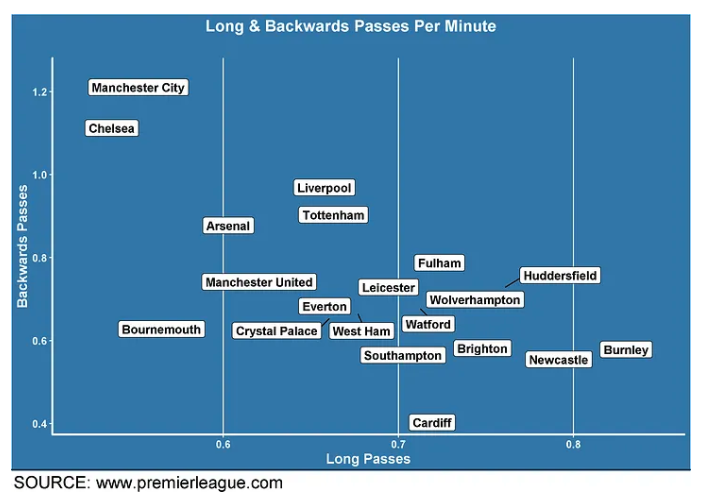